In [57]:
import websocket
import json
import time
import threading
import uuid
import pandas as pd
from datetime import datetime
import logging

class TradingViewDataFetcher:
    def __init__(self, log_level=logging.WARNING):
        """
        Initialize the TradingView data fetcher with configurable logging.
        
        Args:
            log_level: Logging level (default: WARNING to suppress info messages)
        """
        logging.basicConfig(level=log_level, format='%(asctime)s - %(levelname)s - %(message)s')
        self.logger = logging.getLogger(__name__)
        
        # Default WebSocket URL (can be changed if needed)
        self.ws_url = "wss://prodata.tradingview.com/socket.io/websocket"
        
        # Default headers
        self.headers = {
            "Origin": "https://www.tradingview.com",
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
        }

    def fetch_data(self, symbol, exchange="NASDAQ", interval="D", num_bars=100, timeout=20, alt_urls=None):
        """
        Fetch historical price data from TradingView.
        
        Args:
            symbol: Trading symbol (e.g., "AAPL")
            exchange: Exchange name (e.g., "NASDAQ")
            interval: Time interval (e.g., "D" for daily, "W" for weekly, "M" for monthly, 
                     or "1" for 1 minute, "5" for 5 minutes, etc.)
            num_bars: Number of bars to request
            timeout: Maximum time to wait for data in seconds
            alt_urls: List of alternative WebSocket URLs to try if the primary fails
            
        Returns:
            pandas.DataFrame: DataFrame containing OHLCV data
        """
        urls_to_try = [self.ws_url]
        if alt_urls:
            urls_to_try.extend(alt_urls)
        
        for url in urls_to_try:
            self.logger.info(f"Trying WebSocket URL: {url}")
            
            # Reset state for each attempt
            self.session_id = f"qs_{uuid.uuid4().hex[:12]}"
            self.chart_session = f"cs_{uuid.uuid4().hex[:12]}"
            self.received_data = []
            self.error_occurred = False
            
            # Create and start WebSocket
            websocket.enableTrace(False)  # Set to True for verbose WebSocket logs
            ws = websocket.WebSocketApp(
                url,
                header=[f"{k}: {v}" for k, v in self.headers.items()],
                on_open=self._on_open(symbol, exchange, interval, num_bars),
                on_message=self._on_message,
                on_error=self._on_error,
                on_close=self._on_close
            )
            
            wst = threading.Thread(target=ws.run_forever)
            wst.daemon = True
            wst.start()
            
            try:
                # Wait for data
                start_time = time.time()
                while time.time() - start_time < timeout:
                    if self.error_occurred:
                        self.logger.error("Connection error detected, trying next URL if available")
                        break
                    
                    if len(self.received_data) >= num_bars/2:
                        self.logger.info(f"Received sufficient data: {len(self.received_data)} bars")
                        break
                        
                    time.sleep(0.5)
                
                # If we have data, process and return it
                if self.received_data:
                    ws.close()
                    return self._process_data()
                
            except KeyboardInterrupt:
                self.logger.info("Interrupted by user")
            finally:
                ws.close()
        
        # If we get here, all URLs failed
        self.logger.error("Failed to retrieve data from all WebSocket URLs")
        return None

    def _process_data(self):
        """Process the received data into a DataFrame."""
        df = pd.DataFrame(self.received_data)
        if not df.empty:
            df['Date'] = pd.to_datetime(df['Date'], unit='s')
            df = df.sort_values('Date')
            #df.set_index('Date', inplace=True)
            return df
        return None

    def _on_open(self, symbol, exchange, interval, num_bars):
        """Prepare the on_open callback with the required parameters."""
        def on_open_callback(ws):
            self.logger.info("WebSocket connection established")
            
            def run():
                try:
                    self._send_message(ws, "set_auth_token", ["unauthorized_user_token"])
                    time.sleep(0.2)
                    
                    self._send_message(ws, "chart_create_session", [self.chart_session, ""])
                    time.sleep(0.2)
                    
                    self._send_message(ws, "switch_timezone", [self.chart_session, "Etc/UTC"])
                    time.sleep(0.2)
                    
                    full_symbol = f"{exchange}:{symbol}"
                    symbol_payload = json.dumps({"symbol": full_symbol, "adjustment": "splits"})
                    self._send_message(ws, "resolve_symbol", [self.chart_session, "symbol_1", f"={symbol_payload}"])
                    time.sleep(0.2)
                    
                    self._send_message(ws, "create_series", [self.chart_session, "s1", "s1", "symbol_1", interval, num_bars, ""])
                    time.sleep(0.2)
                    
                    self._send_message(ws, "chart_create_study", [self.chart_session, "st1", "st1", "sds_1", full_symbol, interval, num_bars, ""])
                    
                    self.logger.info(f"Requested {num_bars} {interval} bars for {full_symbol}")
                except Exception as e:
                    self.logger.error(f"Error in initialization sequence: {e}")
            
            thread = threading.Thread(target=run)
            thread.daemon = True
            thread.start()
        
        return on_open_callback

    def _send_message(self, ws, method, params):
        """Send a properly formatted message to TradingView WebSocket."""
        try:
            data = json.dumps({"m": method, "p": params})
            message = f"~m~{len(data)}~m~{data}"
            ws.send(message)
            self.logger.debug(f"Sent: {method} - {params[:50]}{'...' if len(str(params)) > 50 else ''}")
        except Exception as e:
            self.logger.error(f"Error sending message {method}: {e}")

    def _on_message(self, ws, message):
        """Handle incoming WebSocket messages."""
        if message == "~h~":
            self.logger.debug("Received heartbeat, sending pong")
            ws.send("~h~")
            return
        
        if not message.startswith("~m~"):
            return
        
        try:
            msg_parts = message.split("~m~")
            for i in range(0, len(msg_parts)):
                if msg_parts[i] and msg_parts[i].isdigit() and i + 1 < len(msg_parts):
                    content = msg_parts[i+1]
                    if content and content.startswith("{"):
                        try:
                            data = json.loads(content)
                            
                            if isinstance(data, dict) and data.get("m") == "timescale_update":
                                self.logger.debug("Found timescale_update message")
                                payload = data.get("p", [])
                                if len(payload) > 1 and isinstance(payload[1], dict):
                                    for series_id, series_data in payload[1].items():
                                        if "s" in series_data and isinstance(series_data["s"], list):
                                            bars_count = len(series_data["s"])
                                            self.logger.debug(f"Found {bars_count} price bars")
                                            
                                            for bar in series_data["s"]:
                                                if "v" in bar and len(bar["v"]) >= 5:
                                                    ts, o, h, l, c = bar["v"][:5]
                                                    volume = bar["v"][5] if len(bar["v"]) > 5 else None
                                                    self.received_data.append({
                                                        "Date": ts,
                                                        "Open": o,
                                                        "High": h,
                                                        "Low": l,
                                                        "Close": c,
                                                        "Volume": volume
                                                    })
                        except json.JSONDecodeError:
                            self.logger.debug(f"Failed to parse JSON: {content[:50]}...")
        except Exception as e:
            self.logger.error(f"Error processing message: {e}")

    def _on_error(self, ws, error):
        """Handle WebSocket errors."""
        self.error_occurred = True
        self.logger.error(f"WebSocket error: {error}")

    def _on_close(self, ws, close_status_code, close_msg):
        """Handle WebSocket connection close."""
        self.logger.debug(f"WebSocket closed: {close_status_code} - {close_msg}")


# Example usage
def get_data(symbol, exchange="NASDAQ", interval="D", bars=5000, log_level=logging.WARNING):
    """
    Simple function to fetch data from TradingView.
    
    Args:
        symbol: Trading symbol (e.g., "AAPL")
        exchange: Exchange name (default: "NASDAQ")
        interval: Time interval (default: "D" for daily)
        bars: Number of bars to request (default: 5000)
        log_level: Logging level (default: WARNING - minimal output)
    
    Returns:
        pandas.DataFrame: DataFrame with OHLCV data or None if failure
    """
    fetcher = TradingViewDataFetcher(log_level=log_level)
    
    # Alternative URLs to try if the primary fails
    alt_urls = [
        "wss://data.tradingview.com/socket.io/websocket",
        "wss://s.tradingview.com/socket.io/websocket"
    ]
    
    return fetcher.fetch_data(
        symbol=symbol,
        exchange=exchange,
        interval=interval,
        num_bars=bars,
        alt_urls=alt_urls
    )
import re 

def occ_to_yahoo(occ):
    """
    Convert OCC option symbol (e.g., TSLA250613P00300000) to Yahoo format (e.g., TSLA250613P300.0).
    Handles tickers of any length and all valid strike formats, always includes one decimal.
    """
    m = re.match(r'^([A-Z0-9]{1,6})(\d{6})([CP])(\d{8})$', occ)
    if not m:
        raise ValueError("Invalid OCC option symbol format")
    symbol, date, opt_type, strike_raw = m.groups()
    strike = int(strike_raw) / 1000
    strike_str = f"{strike:.1f}"  # Always one decimal place

    yahoo = f"{symbol}{date}{opt_type}{strike_str}"
    return yahoo




In [58]:
import yfinance as yf
import pandas as pd
pd.set_option('display.max_rows', None)  # Show all rows

## Fetching options chain for a specific ticker
ticker = "TSLA"
expiry = "2025-06-13"  

def get_options_chain(symbol):
    stock = yf.Ticker(symbol)
    all_options = []
    for expiry in stock.options:
        chain = stock.option_chain(expiry)
        calls = chain.calls.copy()
        puts = chain.puts.copy()
        calls['type'] = 'call'
        puts['type'] = 'put'
        calls['expiry'] = expiry
        puts['expiry'] = expiry
        all_options.append(calls)
        all_options.append(puts)
    options_chain = pd.concat(all_options, ignore_index=True)
    return options_chain.sort_values(by="expiry", ascending=True)
## Adjusts returned Frame 
df = get_options_chain(ticker)
print(df["expiry"].unique())
print(f"{ticker} Current price : {yf.Ticker(ticker).info['currentPrice']}")
print(f"Exchange : {yf.Ticker(ticker).info['exchange']}")
exchange = yf.Ticker(ticker).info['exchange']
df = df[df["expiry"] == expiry]

df.sort_values(by="strike", ascending=True, inplace=True)
key_cols = ['contractSymbol','lastTradeDate','strike', 'type', 'expiry', 'lastPrice', 'bid', 'ask', 'volume', 'openInterest','impliedVolatility']
df = df[[col for col in key_cols if col in df.columns]]


from IPython.display import display, HTML
html = f"""
<div style='height: 200px; overflow: auto; width: fit-content'>
    <style>
        table {{ border-collapse: collapse; }}
        thead th {{
            position: sticky;
            top: 0;
            background-color: Black;
            z-index: 1;
        }}
    </style>
    {df.to_html(index=False)}
</div>
"""



['2025-06-13' '2025-06-20' '2025-06-27' '2025-07-03' '2025-07-11'
 '2025-07-18' '2025-07-25' '2025-08-15' '2025-09-19' '2025-10-17'
 '2025-11-21' '2025-12-19' '2026-01-16' '2026-03-20' '2026-06-18'
 '2026-09-18' '2026-12-18' '2027-01-15' '2027-06-17' '2027-12-17']
TSLA Current price : 302.4
Exchange : NMS


In [ ]:
contract = 'TSLA250613C00305000' # change for contracts


tvcontract = occ_to_yahoo(contract)  # Convert OCC to Yahoo format
data = get_data(tvcontract, exchange="OPRA", interval="1", bars=5000)

data
print(tvcontract)


TSLA250613C305.0


In [60]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.index = data.index - pd.Timedelta(hours=4)
data.tail(10)

,Open,High,Low,Close,Volume
Date,,,,,
2025-06-09 15:06:00,8.25,8.55,8.16,8.16,128.0
2025-06-09 15:07:00,8.21,8.21,8.00,8.02,153.0
2025-06-09 15:08:00,8.06,8.19,7.89,8.19,70.0
2025-06-09 15:09:00,8.22,8.25,8.08,8.20,56.0
2025-06-09 15:10:00,8.19,8.40,8.19,8.40,89.0
2025-06-09 15:11:00,8.50,8.50,8.30,8.34,72.0
2025-06-09 15:12:00,8.40,8.40,8.20,8.30,72.0
2025-06-09 15:13:00,8.30,8.55,8.30,8.55,146.0
2025-06-09 15:14:00,8.50,8.51,8.10,8.20,103.0


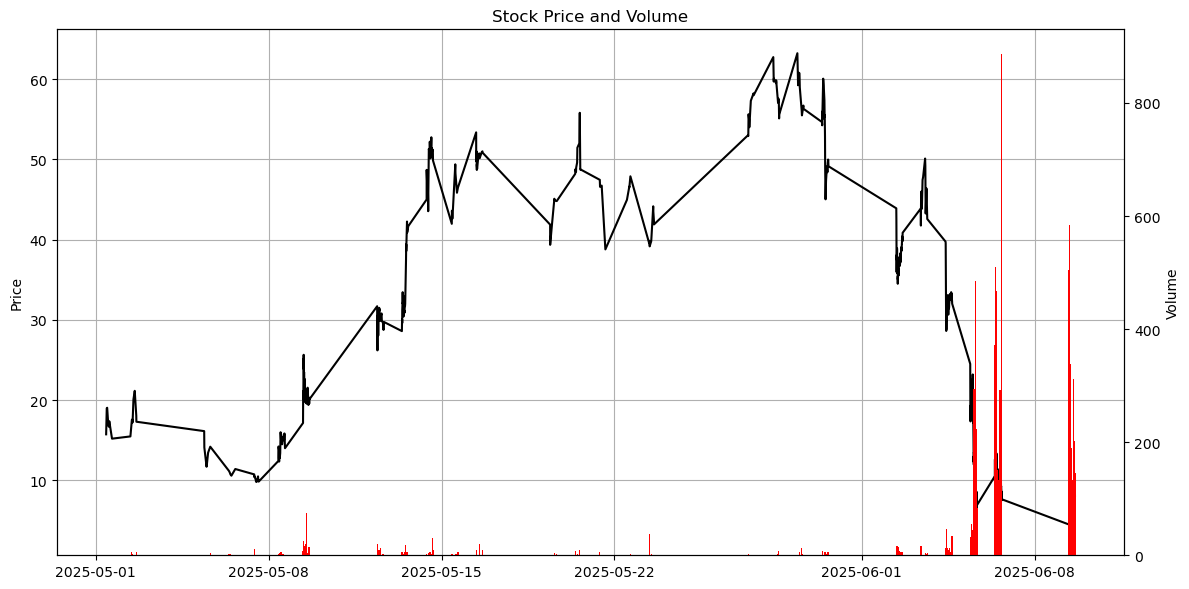

,Open,High,Low,Close,Volume
Date,,,,,
2025-06-09 15:06:00,8.25,8.55,8.16,8.16,128.0
2025-06-09 15:07:00,8.21,8.21,8.00,8.02,153.0
2025-06-09 15:08:00,8.06,8.19,7.89,8.19,70.0
2025-06-09 15:09:00,8.22,8.25,8.08,8.20,56.0
2025-06-09 15:10:00,8.19,8.40,8.19,8.40,89.0
2025-06-09 15:11:00,8.50,8.50,8.30,8.34,72.0
2025-06-09 15:12:00,8.40,8.40,8.20,8.30,72.0
2025-06-09 15:13:00,8.30,8.55,8.30,8.55,146.0
2025-06-09 15:14:00,8.50,8.51,8.10,8.20,103.0


In [61]:

import pandas as pd
import matplotlib.pyplot as plt



import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot closing price
ax1.plot(data.index, data['Close'], color='black', label='Close Price')
ax1.set_ylabel('Price', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_title('Stock Price and Volume')
ax1.grid(True)

# Create a secondary y-axis for volume
ax2 = ax1.twinx()
ax2.bar(data.index, data['Volume'], color='red', alpha=1, label='Volume', width =0.05)
ax2.set_ylabel('Volume', color='black')
ax2.tick_params(axis='y', labelcolor='black')

fig.tight_layout()
plt.show()

data.tail(10)

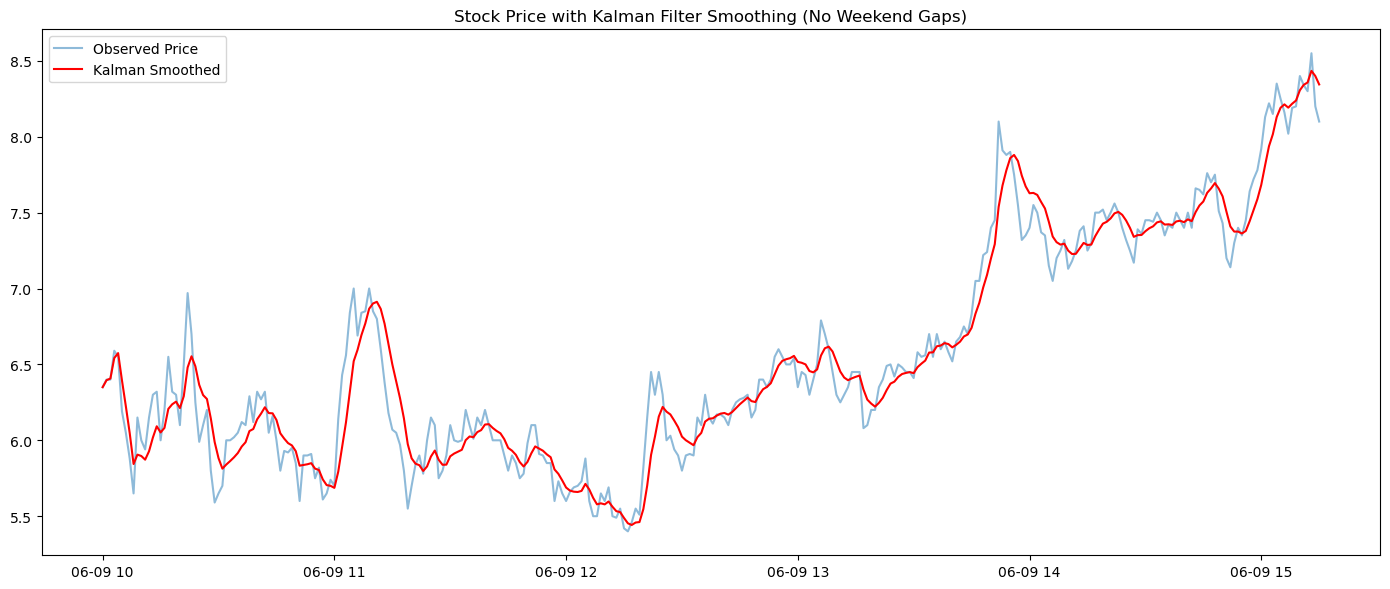

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter

days = 1  # or 7 for a full week

# --- Data Preparation ---

# Remove weekends and keep only regular trading hours
datafix = data[data.index.weekday < 5]
datafix = datafix[(datafix.index.hour < 16) & (datafix.index.hour > 9)]

# Filter for only the last N days in the data
last_date = datafix.index.max()
timer = last_date - pd.Timedelta(days=days)
datafix = datafix[datafix.index >= timer]

# Ensure index is DatetimeIndex
datafix.index = pd.to_datetime(datafix.index)

# --- Kalman Filter Price ---

kf = KalmanFilter(dim_x=2, dim_z=1)
kf.x = np.array([datafix['Close'].iloc[0], 0.])  # initial state (price, velocity)
kf.F = np.array([[1., .1], [0., 1.]])            # state transition matrix
kf.H = np.array([[1., 0.]])                      # measurement function
kf.P *= 1000.                                    # covariance matrix
kf.R = 1.                                        # measurement noise
kf.Q = np.eye(2)*0.05                            # process noise

filtered_state_means = []
for price in datafix['Close']:
    kf.predict()
    kf.update(price)
    filtered_state_means.append(kf.x[0])

datafix['Kalman'] = filtered_state_means

# --- Plotting ---

plt.figure(figsize=(14,6))
plt.plot(datafix.index, datafix['Close'], label='Observed Price', alpha=0.5)
plt.plot(datafix.index, datafix['Kalman'], label='Kalman Smoothed', color='red')
plt.title('Stock Price with Kalman Filter Smoothing (No Weekend Gaps)')
plt.legend()
plt.tight_layout()
plt.show()


In [63]:
##KALMAN FILTER ROC
datafix["Kalman_Roc"] = datafix['Kalman'].pct_change().dropna() * 100  # Convert to percentage change
datafix.tail(10)

,Open,High,Low,Close,Volume,Kalman,Kalman_Roc
Date,,,,,,,
2025-06-09 15:06:00,8.25,8.55,8.16,8.16,128.0,8.213165,0.272735
2025-06-09 15:07:00,8.21,8.21,8.00,8.02,153.0,8.191521,-0.263528
2025-06-09 15:08:00,8.06,8.19,7.89,8.19,70.0,8.217307,0.314796
2025-06-09 15:09:00,8.22,8.25,8.08,8.20,56.0,8.238392,0.256593
2025-06-09 15:10:00,8.19,8.40,8.19,8.40,89.0,8.306092,0.821757
2025-06-09 15:11:00,8.50,8.50,8.30,8.34,72.0,8.341796,0.429852
2025-06-09 15:12:00,8.40,8.40,8.20,8.30,72.0,8.357430,0.187419
2025-06-09 15:13:00,8.30,8.55,8.30,8.55,146.0,8.433989,0.916058
2025-06-09 15:14:00,8.50,8.51,8.10,8.20,103.0,8.399881,-0.404404


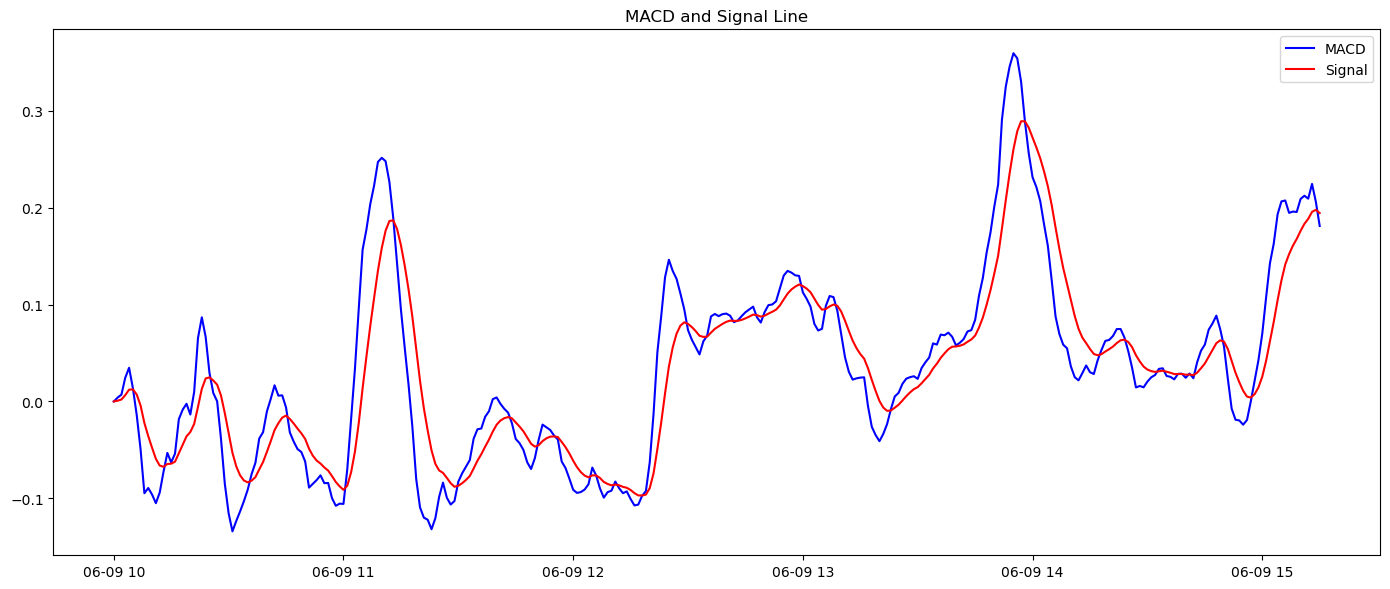

,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist
Date,,,,,,,,,,
2025-06-09 10:00:00,6.05,6.65,5.96,6.35,585.0,6.350000,NaN,0.000000,0.000000,0.000000
2025-06-09 10:01:00,6.37,6.55,6.15,6.40,218.0,6.395823,0.721622,0.003989,0.000798,0.003191
2025-06-09 10:02:00,6.35,6.50,6.35,6.40,128.0,6.407000,0.174749,0.007068,0.002052,0.005016
2025-06-09 10:03:00,6.35,6.65,6.17,6.59,119.0,6.541877,2.105152,0.024557,0.006553,0.018004
2025-06-09 10:04:00,6.55,6.75,6.50,6.55,293.0,6.574497,0.498644,0.034788,0.012200,0.022588
2025-06-09 10:05:00,6.50,6.50,6.10,6.19,143.0,6.394166,-2.742899,0.013690,0.012498,0.001192
2025-06-09 10:06:00,6.13,6.24,6.00,6.05,94.0,6.224194,-2.658234,-0.014164,0.007166,-0.021330
2025-06-09 10:07:00,6.00,6.00,5.69,5.88,108.0,6.047715,-2.835374,-0.049387,-0.004145,-0.045242
2025-06-09 10:08:00,5.86,5.97,5.60,5.65,104.0,5.843836,-3.371174,-0.094768,-0.022270,-0.072498


In [64]:
#MACD
# Calculate MACD and Signal Line
def calculate_macd(df, close_col='Close', fast=12, slow=26, signal=9):
    ema_fast = df[close_col].ewm(span=fast, adjust=False).mean()
    ema_slow = df[close_col].ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - signal_line
    df['MACD'] = macd
    df['Signal'] = signal_line
    df['MACD_Hist'] = macd_hist
    return df

macdata = calculate_macd(datafix, close_col='Close', fast=12, slow=26, signal=9)

# Plotting MACD
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

# Split MACD histogram into positive and negative for color distinction
macd_hist = macdata['MACD_Hist']
pos_hist = macd_hist.copy()
neg_hist = macd_hist.copy()
pos_hist[pos_hist < 0] = 0
neg_hist[neg_hist > 0] = 0

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(macdata.index, macdata['MACD'], label='MACD', color='blue')
plt.plot(macdata.index, macdata['Signal'], label='Signal', color='red')
plt.title('MACD and Signal Line')
plt.legend()
plt.tight_layout()
plt.show()

macdata.head(10)


In [65]:
import pandas as pd
print(tvcontract)
## adjusting strike price for the contract

import pandas_datareader.data as web
import datetime

start = datetime.datetime(2024, 1, 1)
end = datetime.datetime(2025, 6, 9)

# DGS1MO is the FRED code for the 1-Month Treasury Constant Maturity Rate
rate = web.DataReader('DGS1MO', 'fred', start, end)
rfr = rate.tail(1)


TSLA250613C305.0


In [80]:

dateexpiry = "2025-06-13"
expiry = pd.Timestamp(dateexpiry)
datafix['days_to_expiry'] = expiry - datafix.index
print(datafix['days_to_expiry'].tail(1))
datafix['days_to_expiry'] = datafix['days_to_expiry'].dt.days.astype(float)

display(HTML(html))
datafix.tail(10)

Date
2025-06-09 15:15:00   3 days 08:45:00
Name: days_to_expiry, dtype: timedelta64[ns]


contractSymbol,lastTradeDate,strike,type,expiry,lastPrice,bid,ask,volume,openInterest,impliedVolatility
TSLA250613C00050000,2025-06-09 15:06:44+00:00,50.0,call,2025-06-13,246.70,248.90,250.45,5.0,21,0.000010
TSLA250613P00050000,2025-06-09 14:48:14+00:00,50.0,put,2025-06-13,0.01,0.00,0.01,1.0,893,4.500004
TSLA250613C00055000,2025-06-06 19:47:13+00:00,55.0,call,2025-06-13,240.50,243.75,245.35,20.0,12,0.000010
TSLA250613P00055000,2025-06-06 19:14:42+00:00,55.0,put,2025-06-13,0.01,0.00,0.01,20.0,69,4.250005
TSLA250613C00060000,2025-06-04 14:49:05+00:00,60.0,call,2025-06-13,272.03,239.70,241.50,2.0,6,0.000010
TSLA250613P00060000,2025-06-09 15:57:12+00:00,60.0,put,2025-06-13,0.01,0.00,0.01,9.0,16287,4.000005
TSLA250613P00065000,2025-06-06 19:46:23+00:00,65.0,put,2025-06-13,0.01,0.00,0.01,11.0,56614,3.875000
TSLA250613C00065000,2025-06-04 14:49:05+00:00,65.0,call,2025-06-13,267.05,234.35,236.20,2.0,4,0.000010
TSLA250613C00070000,2025-06-06 17:14:32+00:00,70.0,call,2025-06-13,230.77,228.75,230.35,1.0,3,0.000010
TSLA250613P00070000,2025-06-09 13:30:13+00:00,70.0,put,2025-06-13,0.01,0.00,0.01,8.0,22354,3.625001


,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist,strike,Bootstrapped_IV,daysbetween,spot,days_to_expiry
Date,,,,,,,,,,,,,,,
2025-06-09 15:06:00,8.25,8.55,8.16,8.16,128.0,8.213165,0.272735,0.207555,0.141456,0.066099,305,NaN,3 days 08:54:00,8.16,3.0
2025-06-09 15:07:00,8.21,8.21,8.00,8.02,153.0,8.191521,-0.263528,0.194773,0.152120,0.042653,305,NaN,3 days 08:53:00,8.02,3.0
2025-06-09 15:08:00,8.06,8.19,7.89,8.19,70.0,8.217307,0.314796,0.196101,0.160916,0.035185,305,NaN,3 days 08:52:00,8.19,3.0
2025-06-09 15:09:00,8.22,8.25,8.08,8.20,56.0,8.238392,0.256593,0.195703,0.167873,0.027830,305,NaN,3 days 08:51:00,8.20,3.0
2025-06-09 15:10:00,8.19,8.40,8.19,8.40,89.0,8.306092,0.821757,0.209117,0.176122,0.032995,305,NaN,3 days 08:50:00,8.40,3.0
2025-06-09 15:11:00,8.50,8.50,8.30,8.34,72.0,8.341796,0.429852,0.212456,0.183389,0.029067,305,NaN,3 days 08:49:00,8.34,3.0
2025-06-09 15:12:00,8.40,8.40,8.20,8.30,72.0,8.357430,0.187419,0.209460,0.188603,0.020857,305,NaN,3 days 08:48:00,8.30,3.0
2025-06-09 15:13:00,8.30,8.55,8.30,8.55,146.0,8.433989,0.916058,0.224669,0.195816,0.028853,305,NaN,3 days 08:47:00,8.55,3.0
2025-06-09 15:14:00,8.50,8.51,8.10,8.20,103.0,8.399881,-0.404404,0.206105,0.197874,0.008231,305,NaN,3 days 08:46:00,8.20,3.0


In [81]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq

datafix['spot'] = datafix['Close']

def bootstrap_iv_from_price(
    datafix, 
    strike_col='strike', 
    price_col='Close', 
    risk_free_rate=rfr/100, 
    days_to_expiry_col='days_to_expiry',
    spot_col='spot'
):
    """
    Bootstrap Implied Volatility (IV) from option prices using the Black-Scholes model,
    with days to expiry and spot price taken from DataFrame columns.

    Args:
        datafix (pd.DataFrame): DataFrame containing option data.
        strike_col (str): Column name for strike prices.
        price_col (str): Column name for option prices.
        risk_free_rate (float): Risk-free interest rate (annualized, e.g. 0.01 for 1%).
        days_to_expiry_col (str): Column name for days to expiry.
        spot_col (str): Column name for spot price.

    Returns:
        pd.Series: Series containing the bootstrapped implied volatilities.
    """
    def black_scholes_call_price(S, K, T, r, sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

    def implied_volatility_call(price, S, K, T, r):
        def objective_function(sigma):
            return black_scholes_call_price(S, K, T, r, sigma) - price
        try:
            return brentq(objective_function, 1e-6, 5.0)
        except ValueError:
            return np.nan

    iv_series = datafix.apply(
        lambda row: implied_volatility_call(
            row[price_col],
            row[spot_col],
            row[strike_col],
            row[days_to_expiry_col] / 365.0,
            risk_free_rate
        ),
        axis=1
    )
    return iv_series

# Set the spot price column equal to the price column 'Close'
datafix['spot'] = datafix['Close']

# Calculate bootstrapped implied volatility
datafix['Bootstrapped_IV'] = bootstrap_iv_from_price(
    datafix,
    strike_col='strike',
    price_col='Close',
    risk_free_rate=rfr.iloc[0, 0],  # Replace with your risk-free rate value
    days_to_expiry_col='days_to_expiry',
    spot_col='spot'
)


In [82]:
datafix

,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist,strike,Bootstrapped_IV,daysbetween,spot,days_to_expiry
Date,,,,,,,,,,,,,,,
2025-06-09 10:00:00,6.05,6.65,5.96,6.35,585.0,6.350000,NaN,0.000000,0.000000,0.000000,305,NaN,3 days 14:00:00,6.35,3.0
2025-06-09 10:01:00,6.37,6.55,6.15,6.40,218.0,6.395823,0.721622,0.003989,0.000798,0.003191,305,NaN,3 days 13:59:00,6.40,3.0
2025-06-09 10:02:00,6.35,6.50,6.35,6.40,128.0,6.407000,0.174749,0.007068,0.002052,0.005016,305,NaN,3 days 13:58:00,6.40,3.0
2025-06-09 10:03:00,6.35,6.65,6.17,6.59,119.0,6.541877,2.105152,0.024557,0.006553,0.018004,305,NaN,3 days 13:57:00,6.59,3.0
2025-06-09 10:04:00,6.55,6.75,6.50,6.55,293.0,6.574497,0.498644,0.034788,0.012200,0.022588,305,NaN,3 days 13:56:00,6.55,3.0
2025-06-09 10:05:00,6.50,6.50,6.10,6.19,143.0,6.394166,-2.742899,0.013690,0.012498,0.001192,305,NaN,3 days 13:55:00,6.19,3.0
2025-06-09 10:06:00,6.13,6.24,6.00,6.05,94.0,6.224194,-2.658234,-0.014164,0.007166,-0.021330,305,NaN,3 days 13:54:00,6.05,3.0
2025-06-09 10:07:00,6.00,6.00,5.69,5.88,108.0,6.047715,-2.835374,-0.049387,-0.004145,-0.045242,305,NaN,3 days 13:53:00,5.88,3.0
2025-06-09 10:08:00,5.86,5.97,5.60,5.65,104.0,5.843836,-3.371174,-0.094768,-0.022270,-0.072498,305,NaN,3 days 13:52:00,5.65,3.0
